<a href="https://colab.research.google.com/github/AlinaRodina99/diplom/blob/main/Inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision

In [ ]:
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import pandas as pd
import os
from skimage import io
from PIL import Image, ImageFile
import numpy as np
import torch

In [ ]:
torch.manual_seed(17)

In [ ]:
class PaintingsAndPainters(Dataset):
  def __init__(self, csv_file, root_dir, transform):
    self.annotations = pd.read_csv(csv_file, header=None)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    y_label = torch.tensor(self.annotations.iloc[index, 1])
    img_path = self.root_dir + self.annotations.iloc[index, 0]
    image = Image.open(img_path).convert("RGB")
    #transform = transforms.Grayscale()
    #image = transform(image)
    if self.transform:
      image = self.transform(image)
    return (image, y_label)


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = PaintingsAndPainters(csv_file= 'data_and_labels_init.csv', root_dir = '/content/drive/MyDrive/images_init/', transform = preprocess)

In [ ]:
m = len(dataset)
m

5000

In [ ]:
from torch.utils.data import DataLoader,random_split
import torch

In [ ]:
generator_ = torch.Generator().manual_seed(17)
train_data, val_data = random_split(dataset, [int(m-m*0.1), int(m*0.1)], generator = generator_)

In [ ]:
batch_size=20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers = 1)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False, num_workers = 1)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from torch import nn

In [ ]:
model = models.inception_v3(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(2048, 72).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 293MB/s] 


In [ ]:
lr = 0.001

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.fc.parameters(), lr=lr, momentum = 0.9)

In [ ]:
def train_epoch(autoencoder, device, dataloader, loss_fn, optimizer, epoch):
    # Set train mode for both the encoder and the decoder
    train_loss = []
    model.train()
    avg_train_loss = 0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, labels in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        # Evaluate loss
        outputs, lala = model(image_batch)
        loss = loss_fn(outputs, labels)
        # Backward pass
        optimizer.zero_grad()
        print('aa')
        loss.backward()
        print('bb')
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        avg_train_loss += loss / len(dataloader)
    global lr
    lr *= 0.8
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)
    return avg_train_loss

In [ ]:
val_losses = []
val_accs = []
def test_epoch(autoencoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    avg_val_loss = 0
    predicted_labels = []
    real_labels = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, labels in dataloader:
            # Move tensor to the proper device
            #if torch.cuda.is_available():
               #print('yes')
            image_batch = image_batch.to(device)
            labels = labels.to(device)
            # Decode data
            outputs, lala = model(image_batch)
            # Append the network output and the original image to the lists
            loss = loss_fn(outputs, labels)
            avg_val_loss += loss / len(dataloader)
            predicted_labels.append(outputs.argmax(dim = 1))
            real_labels.append(labels)
    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    val_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    return avg_val_loss, val_acc

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/model.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
lr = checkpoint['lr']
lr

2.1872507247830267e-14

In [ ]:
num_epochs = 100
counter = 0
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device, train_loader,loss_fn, optim, epoch)
   val_loss_acc = test_epoch(model, device,valid_loader,loss_fn)
   val_loss = val_loss_acc[0]
   val_acc = val_loss_acc[1]
   
   torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': val_loss,
            'counter': counter,
            'lr' : lr
            }, "/content/drive/MyDrive/model.pt")
   #if epoch > 0:
    
     #checkpoint = torch.load("/content/drive/MyDrive/model.pt")
     #val_loss_prev = checkpoint['loss']
     #if val_loss_prev - val_loss <= 0:
       #counter += 1
       #if counter > 7:
        # break
   print('\n EPOCH {}/{} \t train loss {} \t val loss {} \t val acc {}'.format(epoch + 1, num_epochs,train_loss,val_loss, val_acc))

aa
bb
	 partial train loss (single batch): 4.407687
aa
bb
	 partial train loss (single batch): 4.367241
aa
bb
	 partial train loss (single batch): 4.296681
aa
bb
	 partial train loss (single batch): 4.412703
aa
bb
	 partial train loss (single batch): 4.304887
aa
bb
	 partial train loss (single batch): 4.351839
aa
bb
	 partial train loss (single batch): 4.283214
aa
bb
	 partial train loss (single batch): 4.232338
aa
bb
	 partial train loss (single batch): 4.195522
aa
bb
	 partial train loss (single batch): 4.328717
aa
bb
	 partial train loss (single batch): 4.264086
aa
bb
	 partial train loss (single batch): 4.381166
aa
bb
	 partial train loss (single batch): 4.179344
aa
bb
	 partial train loss (single batch): 4.172641
aa
bb
	 partial train loss (single batch): 4.130239
aa
bb
	 partial train loss (single batch): 4.033024
aa
bb
	 partial train loss (single batch): 4.212395
aa
bb
	 partial train loss (single batch): 4.038821
aa
bb
	 partial train loss (single batch): 4.090642
aa
bb
	 part

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt

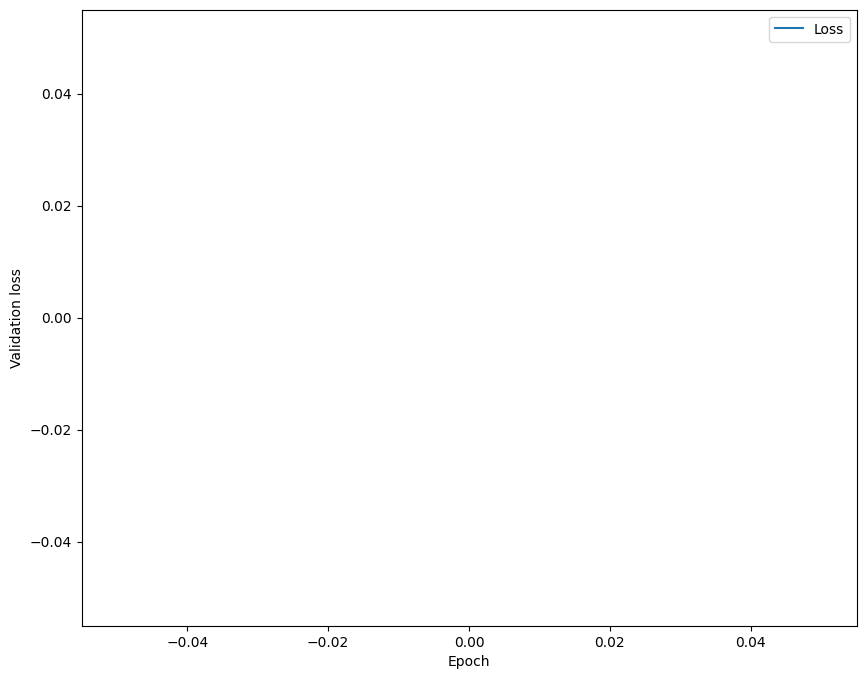

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(val_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
  for image_batch, labels in valid_loader:
    image_batch = image_batch.to(device)
    labels = labels.to(device)
    y_predicted = model(image_batch)
    predicted_labels.append(y_predicted.argmax(dim = 1))
    real_labels.append(labels)
predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
val_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
val_acc

tensor(0.1940)